In [1]:
#hide
from utils import *

hc(
    "F$0$-Conditioned Vocal Sythesis Using WORLD Software",
)

# Quest

1. How to set up WORLD to be used in python?
2. How to perform analysis-synthesis using WORLD vocoder?
3. How to get rid of noise we typically get in the synthesized audio?
4. How to manipulate F0 of speech signal such that it sounds natural?

# Author(s)

Ankit Anand

# About WORLD

Manipulating the $F0$ of a vocal track unlocks countless possibilities, from auto-tuning and data augmentation to guided training for language learners and singers. *WORLD* is a free, open-source software designed for this purpose.

A typical use of *WORLD* vocoder is a 3 to 4 standard steps process.
1. Compute the $F0$ contour of the original audio signal. The *WORLD* software comes with few pitch detection algorithm.
2. Compute harmonic envelope $sp$ from the spectrogram of the audio signal.
3. Compute aperiodic envelope $ap$ using an D4C algorithm.
4. Feed **modified** $F0$ contour, $sp$ and $ap$ to the *synthesizer module* and get the desired audio signal.

In practice, one can modify $F0$, $sp$ and $ap$ as per required before sending it to the *synthesizer module* but in our case we are only interseted in manipulating the $F0$ values.

# Analysis-Synthesis

To test the software's capabilities, we use an analysis–synthesis framework: the complex signal is decomposed into simpler components or parameters, and then reconstructed using only those components to evaluate how accurately the system can reproduce the original signal.

In [5]:
import pyworld as pw
import modusa as ms
import numpy as np
from scipy import signal

In [6]:
# Load a demo speech track
y, sr, title = ms.load("../../../data/fsm-snd/Crocodile 1.mp3", sr=16000, clip=5)
ann = ms.load_ann("../../../data/fsm-snd/Crocodile 1-words.txt", clip=5)

In [7]:
ms.play(y, sr, title="Original Audio")

In [8]:
#hide
def compute_spec(y, sr):
    """
    Compute log-compressed power spectrogram.

    Parameters
    ----------
    y: ndarray
        - Audio signal.
    sr: float | int
        - Sampling rate of the audio signal.
    """
    import librosa
    
    N, H = 1024, 160
    S = librosa.stft(y, n_fft=N, win_length=N, hop_length=H)
    S = np.log(1 + 10*(np.abs(S)**2))
    S_f = np.arange(S.shape[0]) * (sr / N)
    S_t = np.arange(S.shape[1]) * (H / sr)

    return S, S_f, S_t

## Using DIO for Pitch Tracking

In [9]:
# This is as per what is mentioned in the github repo
_f0, t = pw.dio(y, sr)    # raw pitch extractor
f0 = pw.stonemask(y, _f0, t, sr)  # pitch refinement
sp = pw.cheaptrick(y, f0, t, sr)  # extract smoothed spectrogram
ap = pw.d4c(y, f0, t, sr)         # extract aperiodicity
y_synth = pw.synthesize(f0, sp, ap, sr) # synthesize an utterance using the parameters

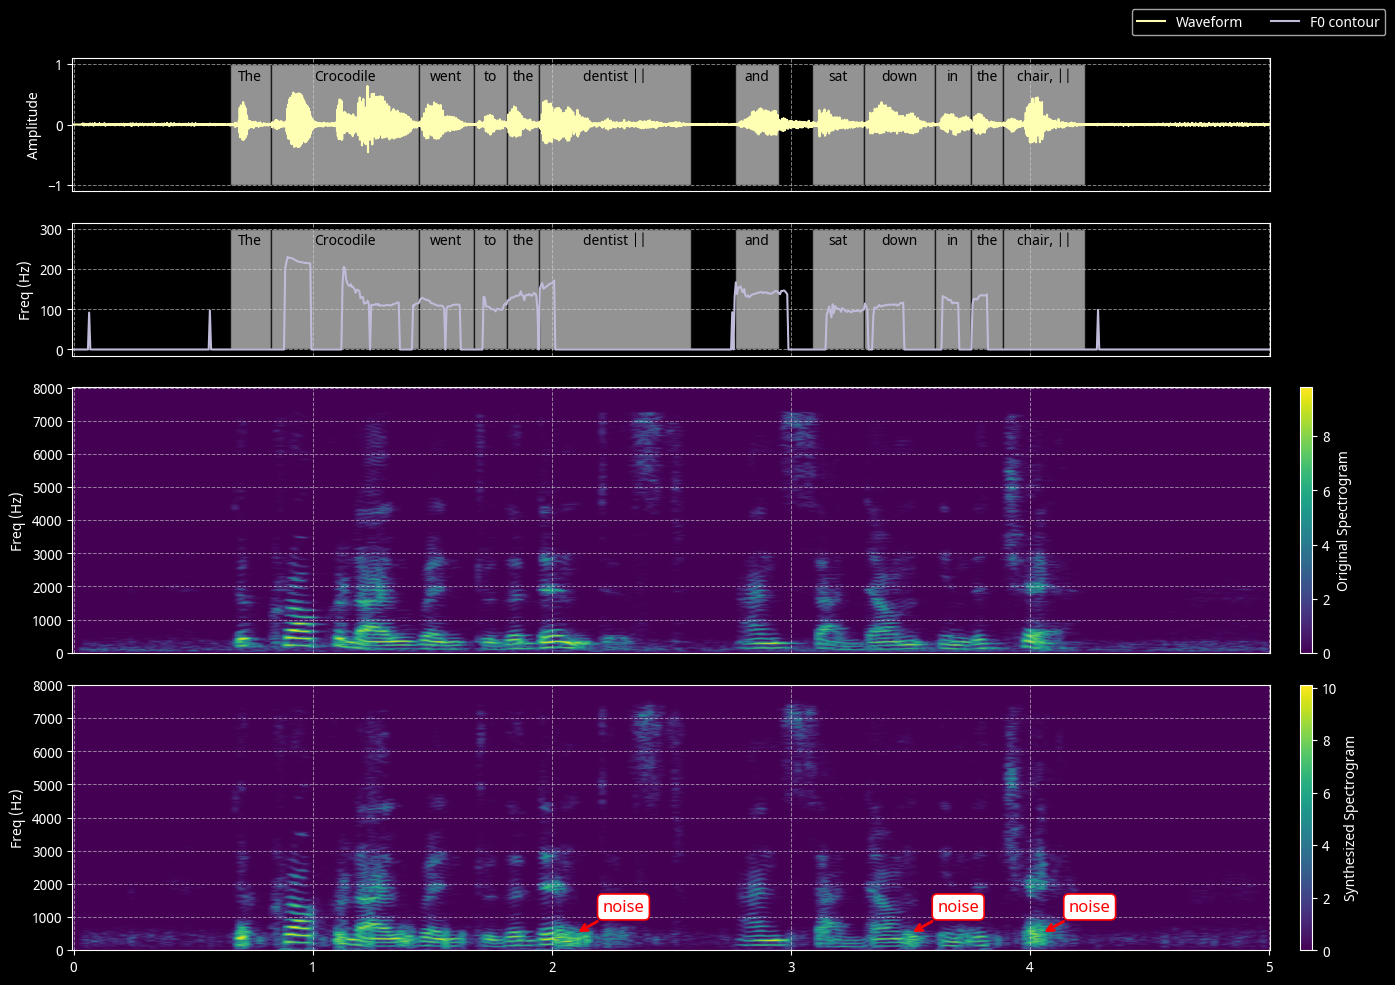

In [10]:
fig = ms.fig("ssmm")

fig.add_signal(y, np.arange(y.size) / sr, label="Waveform", ylabel="Amplitude")
fig.add_annotation(ann, ax=1, ylim=(-1, 1), text_loc="t")

fig.add_signal(f0, t, label="F0 contour", ylabel="Freq (Hz)")
fig.add_annotation(ann, ax=2, ylim=(1, 300), text_loc="t")

fig.add_matrix(*compute_spec(y, sr), ax=3, o="lower", label="Original Spectrogram", ylabel="Freq (Hz)")

fig.add_matrix(*compute_spec(y_synth, sr), ax=4, o="lower", label="Synthesized Spectrogram", ylabel="Freq (Hz)")
fig.add_arrows([(2.1, 500), (3.5, 500), (4.05, 500)], labels="noise", ax=4, text_offset=(0.2, 800))

fig.add_legend(0.9)

In [11]:
ms.play(y_synth, sr, title="Synthesized Audio")

We observe noise in the synthesized audio at regions where the $F0$ contour was not detected reliably. This gives us some indication that a more accurate $F0$ contour may lead to better synthesized audio. *pyworld* also provides another $F0$ detection algorithm called *harvest*. Let’s replace the *dio* module with *harvest* and make some observations.

## Using HARVEST for Pitch Tracking

In [12]:
_f0, t = pw.harvest(y, sr)    # pitch extractor using harvest method
f0 = pw.stonemask(y, _f0, t, sr)  # pitch refinement
sp = pw.cheaptrick(y, f0, t, sr)  # extract smoothed spectrogram
ap = pw.d4c(y, f0, t, sr)         # extract aperiodicity
y_synth = pw.synthesize(f0, sp, ap, sr) # synthesize an utterance using the parameters

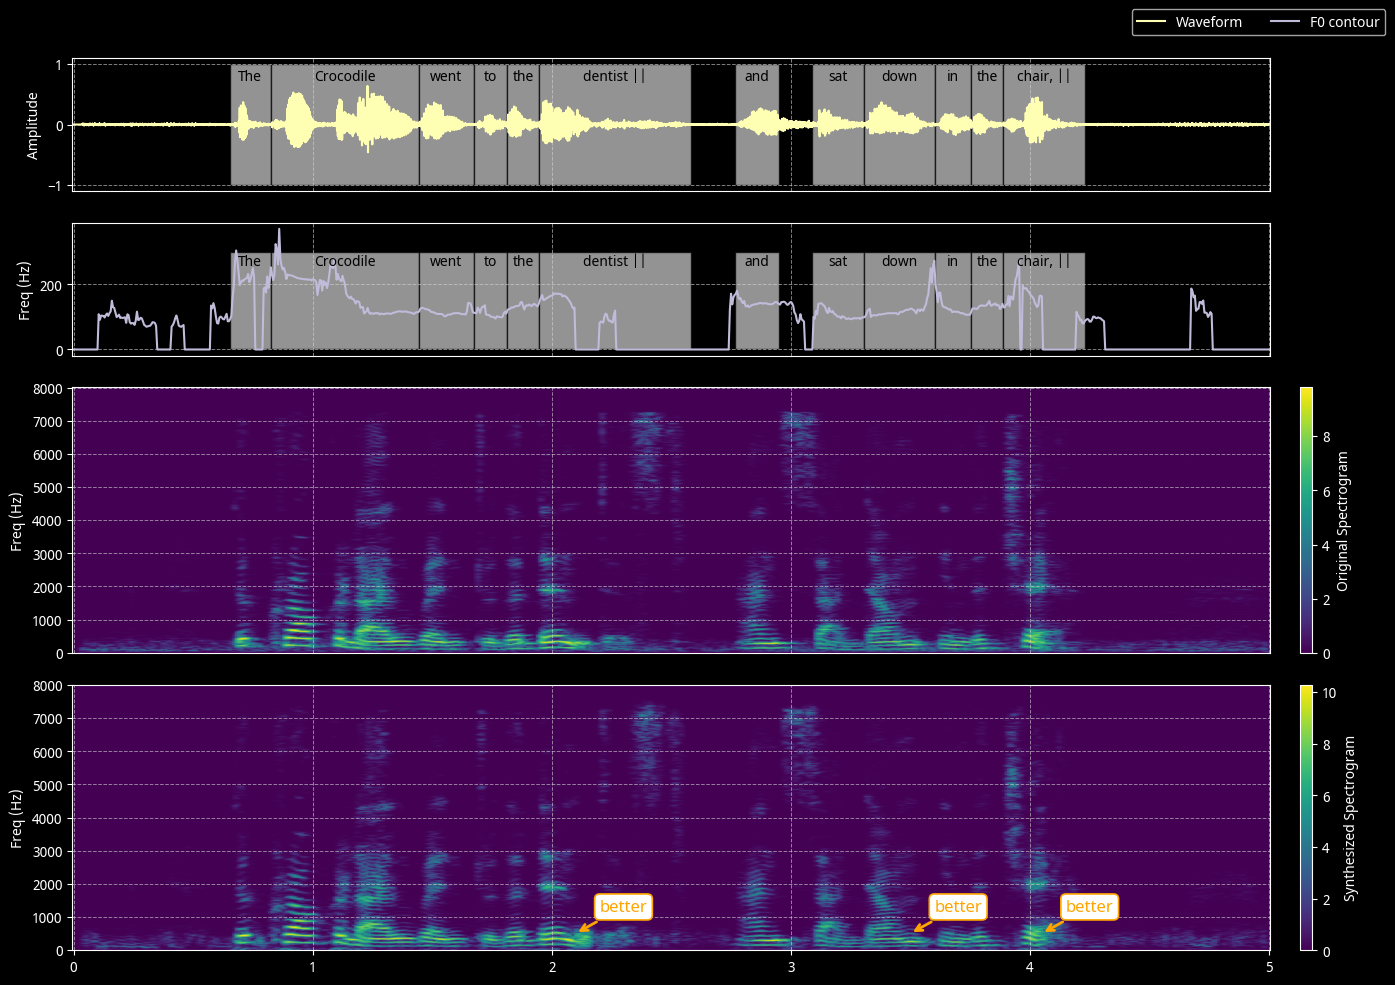

In [13]:
fig = ms.fig("ssmm")

fig.add_signal(y, np.arange(y.size) / sr, label="Waveform", ylabel="Amplitude")
fig.add_annotation(ann, ax=1, ylim=(-1, 1), text_loc="t")

fig.add_signal(f0, t, label="F0 contour", ylabel="Freq (Hz)")
fig.add_annotation(ann, ax=2, ylim=(1, 300), text_loc="t")

fig.add_matrix(*compute_spec(y, sr), ax=3, o="lower", label="Original Spectrogram", ylabel="Freq (Hz)")

fig.add_matrix(*compute_spec(y_synth, sr), ax=4, o="lower", label="Synthesized Spectrogram", ylabel="Freq (Hz)")
fig.add_arrows([(2.1, 500), (3.5, 500), (4.05, 500)], labels="better", ax=4, text_offset=(0.2, 800), c="orange")

fig.add_legend(0.9)

In [14]:
ms.play(y_synth, sr, title="Synthesized Audio")

Using *harvest* algorithm yeild better synthesized audio. 

We can observe that the *harvest* algorithm (with default settings) produces $F0$ values even in noisy regions, but this does not affect synthesis quality. It is recommended to prioritize capturing the $F0$ contour fully, even if it introduces extra values elsewhere.

## Tuning the Parameters for DIO/Harvest

Let's try to set the parameters to get rid of some of the noise in the $F0$ detection. 

I just realised that *harvest* algorithm does not give a voiced/unvoiced cost to suppress the $F0$ values in low energy regions. Although *dio* algorithm gives more controls than *harvest* but imo it is much better to use praat pitch detection algorithm.

## Using PRAAT for Pitch Tracking

In [15]:
# Helper functions
import parselmouth
from scipy.interpolate import interp1d

def get_pitch_contour(y, sr, time_step=0.01, in_midi=False, attenuate_top=None):
    """
    Compute pitch contour using autocorrelation method from Praat.

    Parameters
    ----------
    y: ndarray
       Audio signal.
    sr: int
        Sampling rate of the audio signal.
    time_step: float
        - Timestep in sec.
        - Default: 0.01
    attenuate_top: float
        - Any frequency above this will be made 0.
    Returns
    -------
    ndarray
        - Pitch contour array.
    ndarray
        - Timestamp (sec).
    """
    
    snd = parselmouth.Sound(values=y, sampling_frequency=sr)
    pitch_obj = snd.to_pitch_ac(
        time_step=time_step,
        pitch_floor=75.0, 
        max_number_of_candidates=15, 
        very_accurate=True, 
        silence_threshold=0.04,
        voicing_threshold=0.1,
        octave_cost=0.05, 
        octave_jump_cost=0.8, 
        voiced_unvoiced_cost=0.6,
        pitch_ceiling=600
    )
    f0 = pitch_obj.selected_array['frequency']
    f0_t = pitch_obj.ts()

    if in_midi is True:
        mask = f0 > 0
        f0[mask] = librosa.hz_to_midi(f0[mask])
    
    if attenuate_top:
        f0 = np.where(f0 > attenuate_top, 0, f0)
    return f0, f0_t

In [16]:
f0_praat, f0_t_praat = get_pitch_contour(y, sr, time_step=0.005) # time_step = 5 ms for WORLD by default
f0_praat, f0_t_praat = get_pitch_contour(y, sr, in_midi=False, attenuate_top=260)
f0_praat = interp1d(f0_t_praat, f0_praat, fill_value="extrapolate")(t)
sp = pw.cheaptrick(y, f0_praat, t, sr)  # extract smoothed spectrogram
ap = pw.d4c(y, f0_praat, t, sr)         # extract aperiodicity

# f0_praat[288:334] = f0_praat[288:334] * (2** (5/12)) # went
# f0_praat = f0_praat * (2** (5/12))

y_synth = pw.synthesize(f0_praat, sp, ap, sr) # synthesize an utterance using the parameters

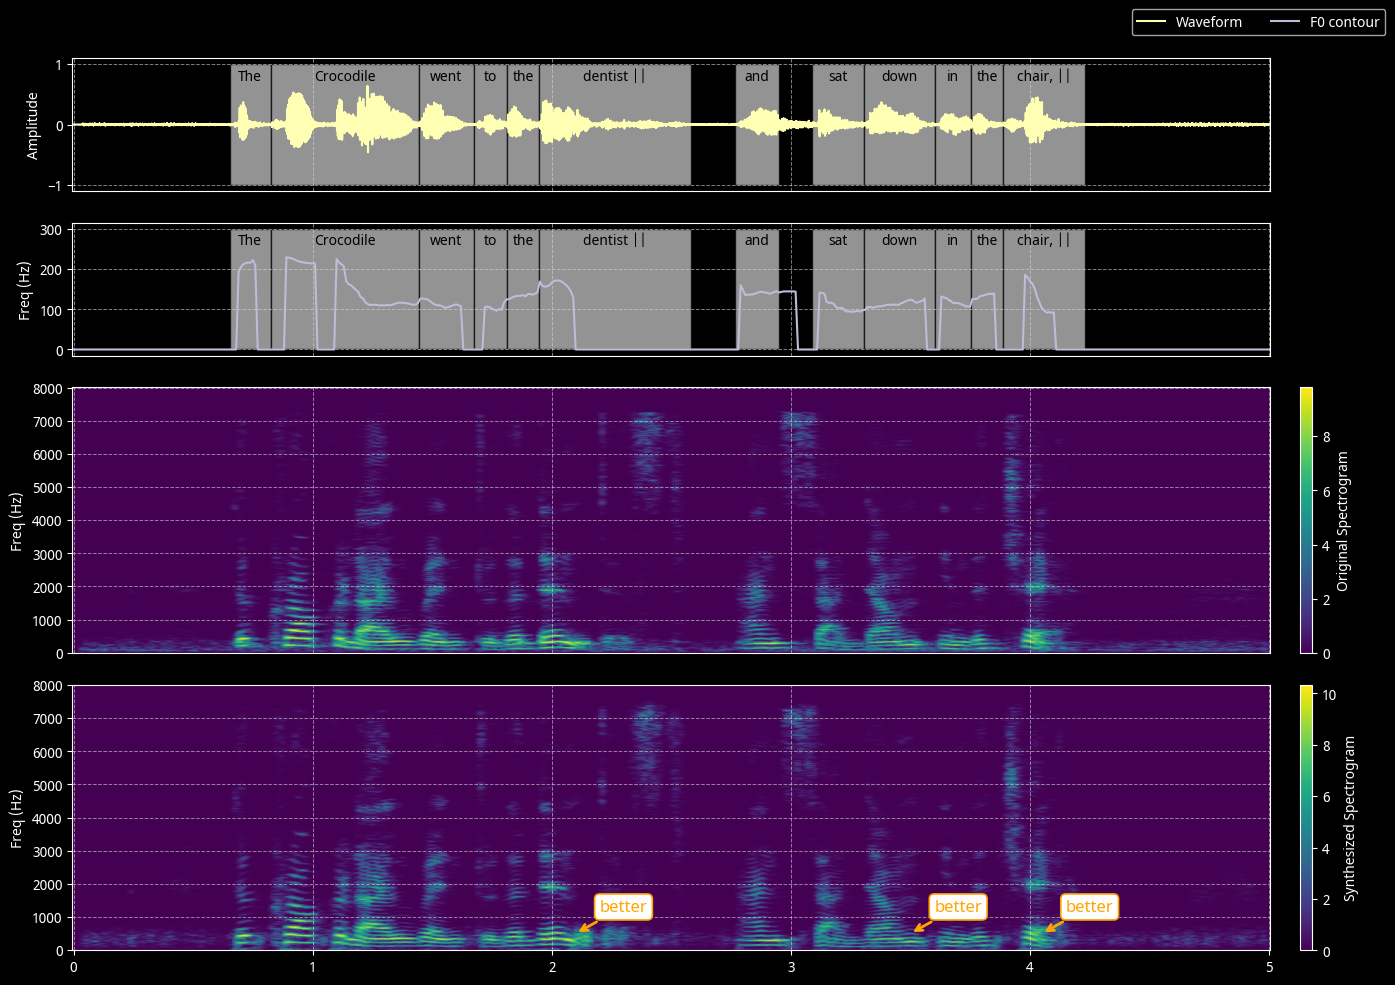

In [17]:
fig = ms.fig("ssmm")

fig.add_signal(y, np.arange(y.size) / sr, label="Waveform", ylabel="Amplitude")
fig.add_annotation(ann, ax=1, ylim=(-1, 1), text_loc="t")

fig.add_signal(f0_praat, t, label="F0 contour", ylabel="Freq (Hz)")
fig.add_annotation(ann, ax=2, ylim=(1, 300), text_loc="t")

fig.add_matrix(*compute_spec(y, sr), ax=3, o="lower", label="Original Spectrogram", ylabel="Freq (Hz)")

fig.add_matrix(*compute_spec(y_synth, sr), ax=4, o="lower", label="Synthesized Spectrogram", ylabel="Freq (Hz)")
fig.add_arrows([(2.1, 500), (3.5, 500), (4.05, 500)], labels="better", ax=4, text_offset=(0.2, 800), c="orange")

fig.add_legend(0.9)

In [18]:
ms.play(y_synth, sr)

In [19]:
y, sr, title = ms.load("../../../data/mydata/ye_shaam_mastani.wav", sr=16000)

In [20]:
f0_praat, f0_t_praat = get_pitch_contour(y, sr, time_step=0.005)
f0_praat, f0_t_praat = get_pitch_contour(y, sr, in_midi=False, attenuate_top=None)
_, t = pw.dio(y, sr)
f0_praat = interp1d(f0_t_praat, f0_praat, fill_value="extrapolate")(t)
sp = pw.cheaptrick(y, f0_praat, t, sr)  # extract smoothed spectrogram
ap = pw.d4c(y, f0_praat, t, sr)         # extract aperiodicity

# f0_praat[288:334] = f0_praat[288:334] * (2** (5/12)) # went
f0_praat = f0_praat * (2** (1/12))

y_synth = pw.synthesize(f0_praat, sp, ap, sr) # synthesize an utterance using the parameters

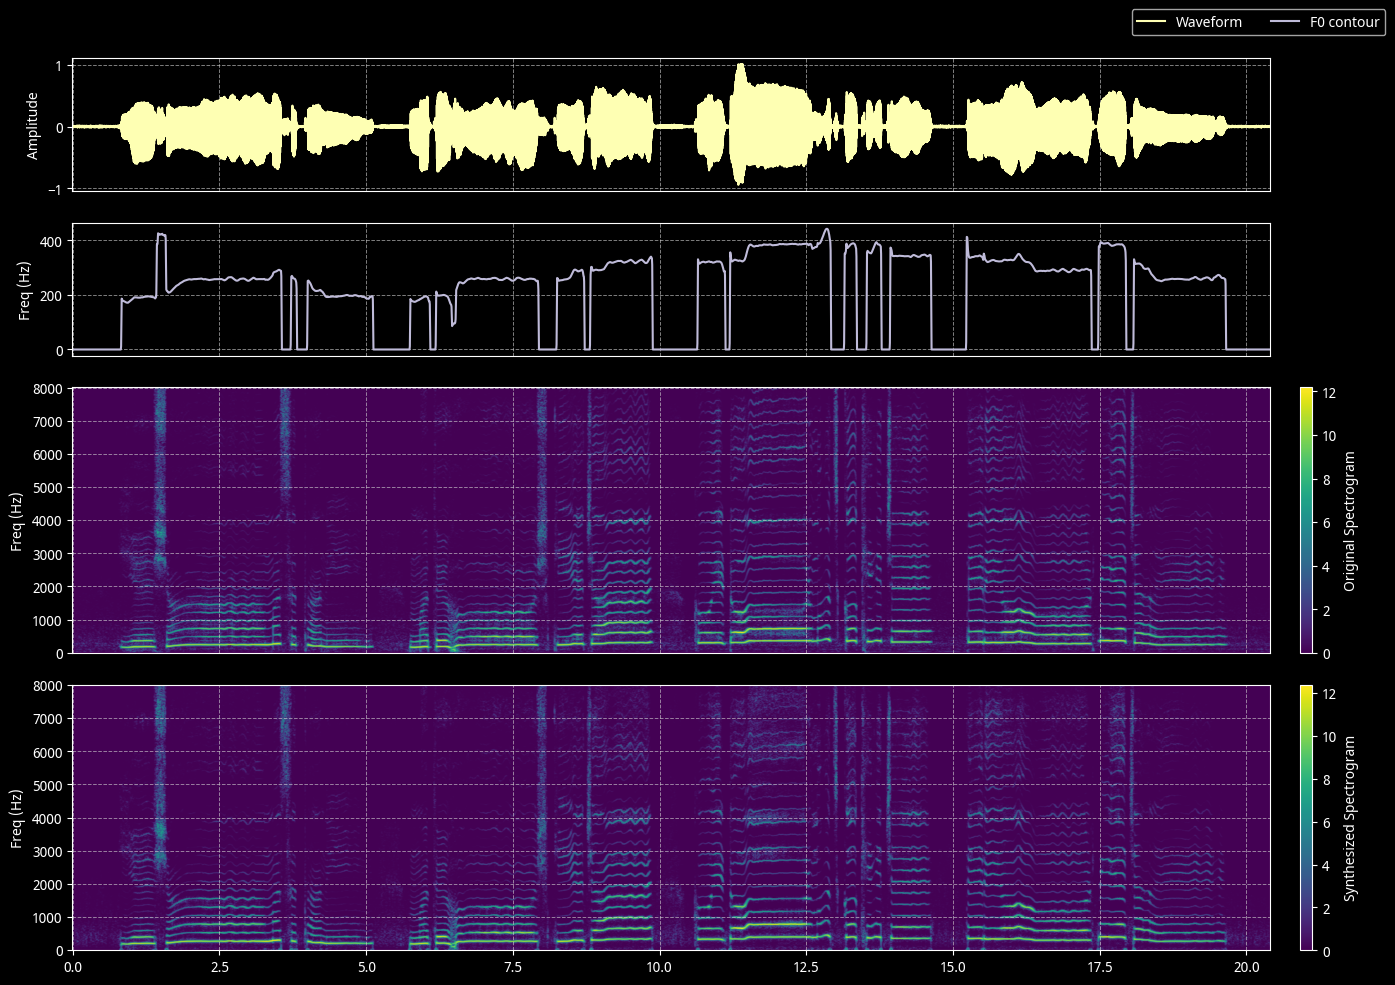

In [21]:
fig = ms.fig("ssmm")

fig.add_signal(y, np.arange(y.size) / sr, label="Waveform", ylabel="Amplitude")

fig.add_signal(f0_praat, t, label="F0 contour", ylabel="Freq (Hz)")

fig.add_matrix(*compute_spec(y, sr), ax=3, o="lower", label="Original Spectrogram", ylabel="Freq (Hz)")

fig.add_matrix(*compute_spec(y_synth, sr), ax=4, o="lower", label="Synthesized Spectrogram", ylabel="Freq (Hz)")

fig.add_legend(0.9)